In [1]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as opt
import scipy.signal as sig

In [2]:
base_path = "/Volumes/DATA/"
sphere_data = ["20230925/meas/1",
               "20230925/meas/2",
                "20230925/meas/3",
                "20230925/meas/4",
                "20230925/meas/5",
                "20230925/meas/6",
                "20230925/meas/7",
                "20230925/meas/8",
                "20230925/meas/9",
                "20230925/meas/10",
                "20230925/meas/11",
                "20230925/meas/12",]
file_label= '20230925'
remake_files = True

In [3]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

Drive frequency is: 111.08 Hz


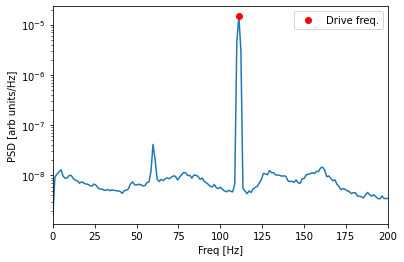

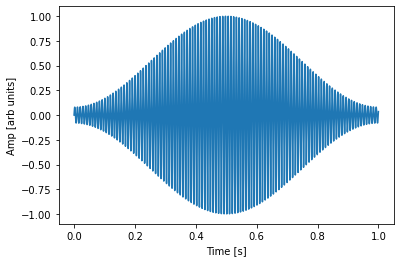

In [4]:
## make a template for the charge measurement
importlib.reload(bu)
dat, attr, _ = bu.get_data(data_list[0])
drive_template, drive_freq = bu.correlation_template_cw(dat, attr, length=1, make_plots=True)

In [6]:
importlib.reload(bu)

if(remake_files):
    charge_vec = []
    corr_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=2**16)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])

    charge_vec = np.array(charge_vec)
    np.save("charge_steps_%s.npy"%file_label, charge_vec)
    np.save("charge_steps_vec_%s.npy"%file_label, corr_vec)
else:
    charge_vec = np.load("charge_steps_%s.npy"%file_label)
    corr_vec = np.load("charge_steps_vec_%s.npy"%file_label)

working on file 0: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_0.h5
working on file 10: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_10.h5
working on file 20: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_20.h5
working on file 30: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_30.h5
working on file 40: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_40.h5
working on file 50: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_50.h5
working on file 60: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_60.h5
working on file 70: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_70.h5
working on file 80: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_80.h5
working on file 90: /Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_90.h5
working on file 100: /Volumes/DATA/20230925/meas/2/LPmbar_xyzcool_8.h5
working on file 110: /Volumes/DATA/20230925/meas/2/LPmbar_xyzcool_18.h5
working on file 120: /Volumes/DATA/20230925/meas/2/LPmbar_xyzcool_28.h5
working on file 130: /Volumes/DATA/20230925/meas/2/LPmbar_xyzcool_38.h5
worki

In [22]:
## Make a list of folder numbers 

folder_vec = []
for f in data_list:
    parts = f.split('/')
    folder_vec.append([int(parts[5])]*16)
folder_vec = np.ndarray.flatten(np.array(folder_vec))
print(folder_vec)


[ 1  1  1 ... 12 12 12]


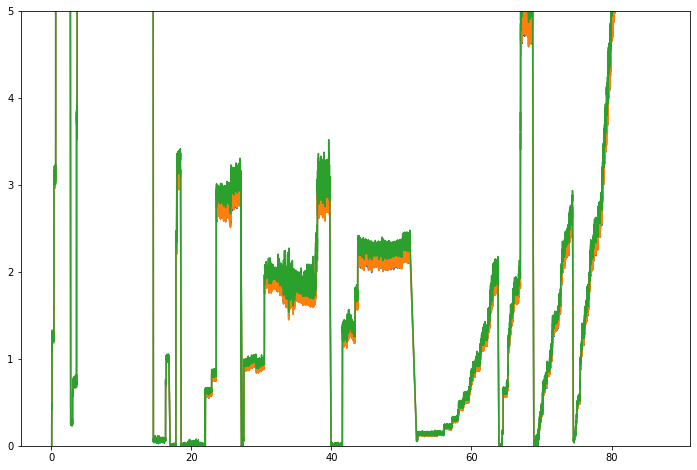

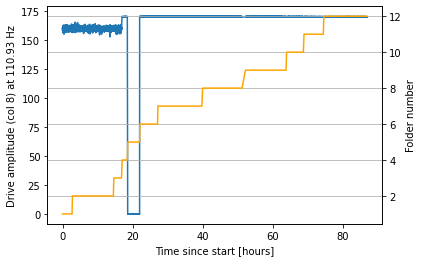

In [23]:
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600
plt.figure(figsize=(12,8))
#plt.subplot(2,1,1)
plt.plot(time_hours, corr_vec[:,0]*1.02)
plt.plot(time_hours, corr_vec[:,1])
plt.plot(time_hours, corr_vec[:,2]*1.06)
#plt.xlim(0.3, 0.7)
plt.ylim(0, 5)
#plt.subplot(2,1,2)

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 110.93 Hz")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)


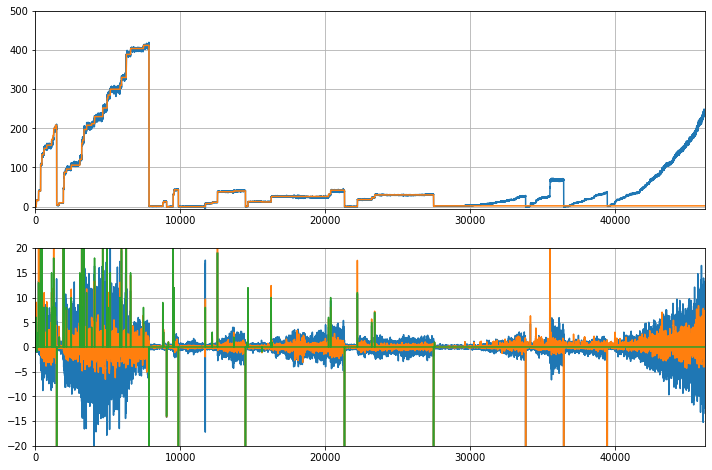

In [249]:
cal_fac = 0.072
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])
recal[1500:7839] = 0.95


xmin, xmax = 0, len(corr_vec)
ymin, ymax = -5, 500
init_charge = -1

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
bpts = (np.abs(dv) < 2) | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
plt.plot(dv2)
## fix up missed steps
step_vals = np.loadtxt("step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-20,20)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')

In [ ]:
## now make some cleaned up versions of the plots versus time
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)


In [91]:
idx=10000
print(data_list[int(idx/16)])

/Volumes/DATA/20230925/meas/5/LPmbar_xyzcool_8.h5


16.0
16.0


(100.0, 120.0)

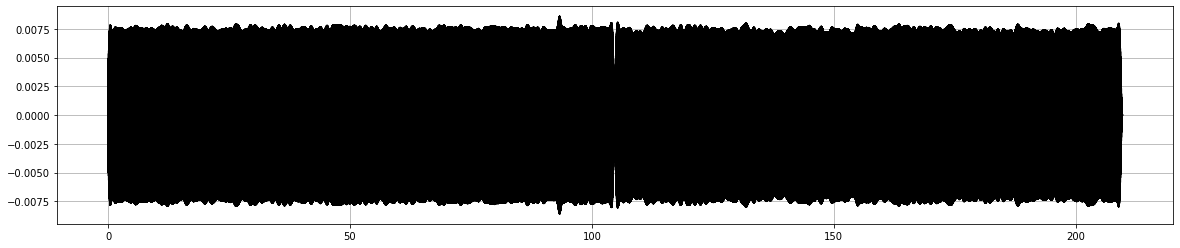

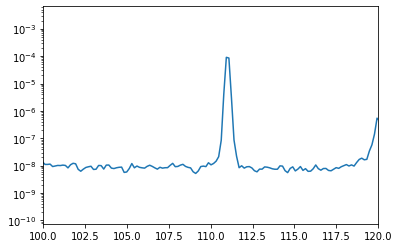

In [8]:
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=9000
nfiles = 2
plt.figure(figsize=(20,4))
for nf in range(nfiles):
    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    #fn = np.array([104, 118])/5000
    fn = np.array([110, 112])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.plot(tvec,fdat, 'k')
    plt.grid(True)
    #plt.xlim(60,65)
    #plt.ylim(0.06, 0.10)

plt.figure()
f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
plt.semilogy(f,p)
plt.xlim(100,120)